In [1]:
import os
import pandas as pd
from copy import deepcopy
from collections import defaultdict
import geopandas as gp
from matplotlib import pyplot as plt
%matplotlib inline

# PAM - Getting Started

**Pandemic Activity Modelling/Modifying**

This notebook is a quick spin through PAM. Intended to provide a technical overview and inspire further research and development.

### Load Data

Here we load simple travel diary data of London commuters. This is a very simple 0.1% sample of data about work and education commutes from the 2011 census. Because we're sharing this date - we've aggregated locations to borough level and randomized personal attributes - so don't get too excited about the results.

The data is available in `pam/example_data`.

In [2]:
# these paths assume you are running this notebook from the 'examples' directory
trips = pd.read_csv(os.path.join("data", "example_data", 'example_travel_diaries.csv'), index_col = "uid")
attributes = pd.read_csv(os.path.join("data", "example_data", 'example_attributes.csv'), index_col = "pid")

In [3]:
trips.head(10)

,pid,hid,seq,hzone,ozone,dzone,purp,mode,tst,tet,freq
uid,,,,,,,,,,,
0,census_0,census_0,0,Harrow,Harrow,Camden,work,pt,444,473,1000
1,census_0,census_0,1,Harrow,Camden,Harrow,work,pt,890,919,1000
2,census_1,census_1,0,Greenwich,Greenwich,Tower Hamlets,work,pt,507,528,1000
3,census_1,census_1,1,Greenwich,Tower Hamlets,Greenwich,work,pt,1065,1086,1000
4,census_2,census_2,0,Croydon,Croydon,Croydon,work,pt,422,425,1000
5,census_2,census_2,1,Croydon,Croydon,Croydon,work,pt,917,920,1000
6,census_3,census_3,0,Haringey,Haringey,Redbridge,work,pt,428,447,1000
7,census_3,census_3,1,Haringey,Redbridge,Haringey,work,pt,1007,1026,1000
8,census_4,census_4,0,Hounslow,Hounslow,"Westminster,City of London",work,car,483,516,1000


### Build Activity Plans

First we convert the travel diary data to Activity Plans:

In [4]:
from pam import read
population = read.load_travel_diary(trips, attributes, trip_freq_as_person_freq=True)

Using tour based purpose parser (recommended)
Adding pid->hh mapping to persons_attributes from trips.
Adding home locations to persons attributes using trips attributes.
Using freq of 'None' for all trips.


Let's check out an example Activity Plan and Attributes:

In [5]:
household = population.households['census_12']
person = household.people['census_12']
person.print()

Person: census_12
{'gender': 'female', 'job': 'education', 'occ': 'white', 'inc': 'high', 'hzone': 'Croydon'}
0:	Activity(act:home, location:Croydon, time:00:00:00 --> 07:06:00, duration:7:06:00)
1:	Leg(mode:pt, area:Croydon --> Tower Hamlets, time:07:06:00 --> 07:45:00, duration:0:39:00)
2:	Activity(act:education, location:Tower Hamlets, time:07:45:00 --> 15:54:00, duration:8:09:00)
3:	Leg(mode:pt, area:Tower Hamlets --> Croydon, time:15:54:00 --> 16:33:00, duration:0:39:00)
4:	Activity(act:home, location:Croydon, time:16:33:00 --> 00:00:00, duration:7:27:00)


Before we do any activity modification - we create a simple function to extract some example statistics. We include this as a simple demo, but would love to add more.

Note that activity plans allow us to consider detailed **joint** segmentations, such as socio-economic, spatial, temporal, modal, activity sequence and so on.

In [6]:
def print_simple_stats(population):
    """
    Print some simple population statistics.
    """
    time_at_home = 0
    travel_time = 0 
    low_income_central_trips = 0
    high_income_central_trips = 0
    
    for hid, hh in population.households.items():
        for pid, person in hh.people.items():
            freq = person.freq
            
            for p in person.plan:
                if p.act == 'travel':
                    duration = p.duration.seconds * freq / 3600
                    travel_time += duration
                    
                    if p.end_location.area == "Westminster,City of London":
                        if person.attributes['inc'] == "low":
                            low_income_central_trips += freq
                            
                        elif person.attributes['inc'] == "high":
                            high_income_central_trips += freq
                    
                else:  # activity
                    if p.act == 'home':
                        duration = p.duration.seconds * freq / 3600
                        time_at_home += duration
                        
    print(f"Population total time at home: {time_at_home/1000000:.2f} million hours")
    print(f"Population total travel time: {travel_time/1000000:.2f} million hours")
    print(f"Low income trips to Central London: {low_income_central_trips} trips")
    print(f"High income trips to Central London: {high_income_central_trips} trips")
                        

In [7]:
print_simple_stats(population)

Population total time at home: 0.76 million hours
Population total travel time: 0.03 million hours
Low income trips to Central London: 3000 trips
High income trips to Central London: 4000 trips


In [8]:
def plot_simple_stats(population):
    """
    Plot some simple population statistics.
    """
    geoms = gp.read_file(os.path.join("data", "example_data", "geometry.geojson"))

    departures = defaultdict(int)
    arrivals = defaultdict(int)
    
    for hid, hh in population.households.items():
        for pid, person in hh.people.items():
            freq = person.freq
            
            for p in person.plan:
                if p.act == 'travel':
                    departures[p.start_location.area] += freq
                    arrivals[p.end_location.area] += freq
    geoms['departures'] = geoms.NAME.map(departures)
    geoms['arrivals'] = geoms.NAME.map(arrivals)
        
    fig, ax = plt.subplots(1,2, figsize=(16,6))
    for i, name in enumerate(['departures', 'arrivals']):
        
        ax[i].title.set_text(name)
        geoms.plot(name, ax=ax[i])
        ax[i].axis('off')


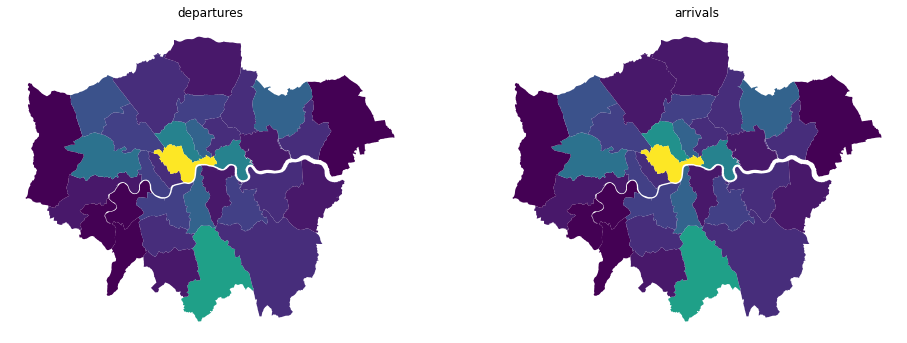

In [9]:
plot_simple_stats(population)

### Scenarios

Our 2011 baseline London population of commuters seems sensible, they spend about 50 million hours at home and 1.6 million hours travelling.

But what if we want to try and build some more up to date scenarios?

We consider two scenarios from a combination of policies:

Scenario A - Do Minimum:
1. A household will be quarantined with p=0.025 (for example due to a possitive virus test within the household)
2. A person will be staying at home (self isolating) with p=0.1 (for example due to being a vulnerable person)

Scenario B - Lockdown:
1. As above plus education and work activities will be removed and plans adjusted with p=0.9 (for example because schools and work places are closed)

In [10]:
from pam import policy
from pam.policy import apply_policies

policy1 = policy.HouseholdQuarantined(probability=0.025)
policy2 = policy.PersonStayAtHome(probability=0.1)
policy3 = policy.RemoveHouseholdActivities(['education', 'work'], probability=0.9)

do_minimum = apply_policies(population, [policy1, policy2])
lockdown = apply_policies(population, [policy1, policy2, policy3])

### Review

So this has been a pretty quick and dirty demo. But we can still take a look at our new population scenario stats below. Obviously we'd like to add some more analytics... some viz... some validation... then output new travel plans and OD matrices for use in other models.

Population total time at home: 0.69 million hours
Population total travel time: 0.02 million hours
Low income trips to Central London: 3000 trips
High income trips to Central London: 4000 trips


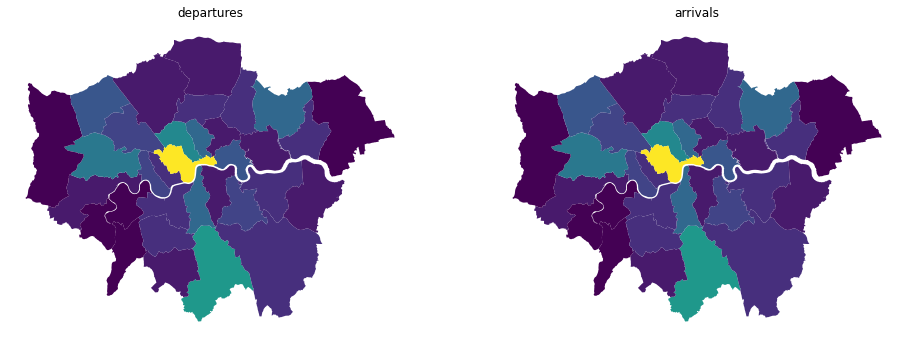

In [11]:
print_simple_stats(do_minimum)
plot_simple_stats(do_minimum)

Population total time at home: 0.06 million hours
Population total travel time: 0.00 million hours
Low income trips to Central London: 1000 trips
High income trips to Central London: 0 trips


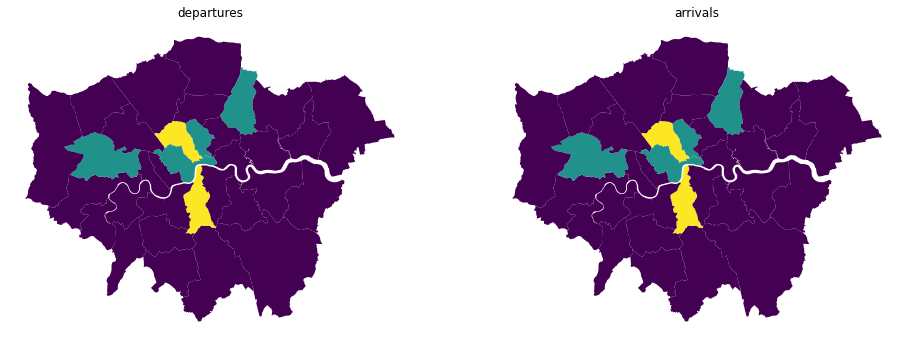

In [12]:
print_simple_stats(lockdown)
plot_simple_stats(lockdown)